In [2]:
from glob import glob
import os, cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
from keras.layers import Input, concatenate
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Dropout
from keras.utils.vis_utils import plot_model

In [3]:
## define params

DIR = "koeln"
SEED = 650
IMG_SIZE = 256
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

BATCH_SIZE = 16
NUM_CLASSES = 10

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
# for file in os.listdir(DIR):
#     if file.endswith(".jp2"):
#         img = Image.open(os.dir.join(DIR,file))
#         img.save(os.path.join(DIR,file[0:-4] + ".png"))

In [5]:
def load_data(dir):
    images = glob(os.path.join(dir, "image\\*.png"))
    masks = glob(os.path.join(dir, "mask\\*.tif"))

    return images, masks

def read_image(dir):
    x = cv2.imread(dir, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMG_SIZE, IMG_SIZE))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(dir):
    x = cv2.imread(dir, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMG_SIZE, IMG_SIZE))
    x = x / 255.0
    x = np.expand_dims(x, axis=-1)
    x = x.astype(np.float32)
    return x
    
def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        x = read_image(x)
        y = read_mask(y)

        return x, y

    images, masks = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    images.set_shape([IMG_SIZE, IMG_SIZE, 3])
    masks.set_shape([IMG_SIZE, IMG_SIZE, 1])

    return images, masks


In [6]:
images, masks = load_data(DIR)
print(f"Images: {len(images)} - Masks: {len(masks)}")

LEN_DATA = len(images)

geonrw = tf.data.Dataset.from_tensor_slices((images, masks))
geonrw = geonrw.shuffle(buffer_size=LEN_DATA)
geonrw = geonrw.map(preprocess)
geonrw = geonrw.batch(8)
geonrw = geonrw.prefetch(buffer_size=AUTOTUNE)

Images: 479 - Masks: 479


In [7]:
geonrw_tr = geonrw.take(int(LEN_DATA / BATCH_SIZE * 0.3))
geonrw_te = geonrw.skip(int(LEN_DATA / BATCH_SIZE * 0.3))

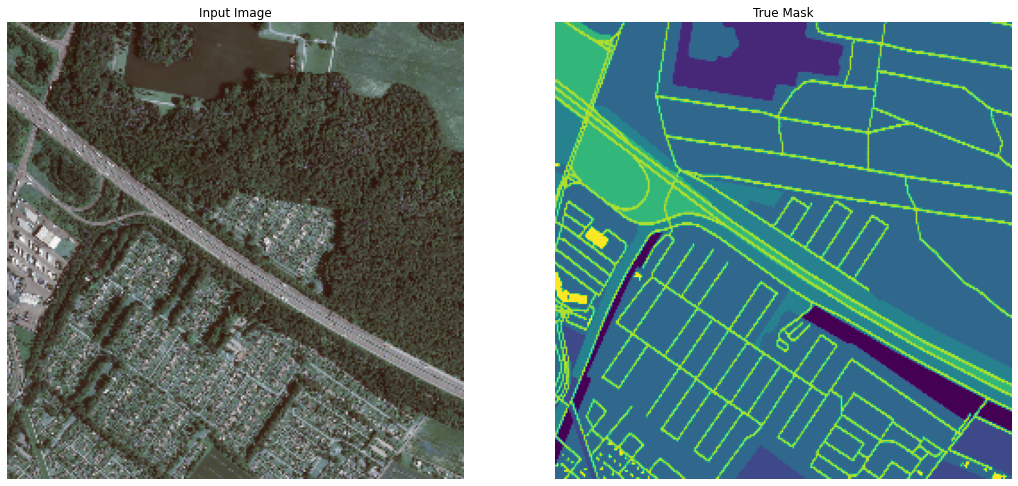

In [8]:
def display_sample(display_list):

    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
for image, mask in geonrw_tr.take(1):
    sample_image, sample_mask = image, mask

display_sample([sample_image[0], sample_mask[0]])

In [9]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [10]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = MaxPooling2D(2)(f)
   p = Dropout(0.3)(p)
   return f, p

In [11]:
def upsample_block(x, conv_features, n_filters):
   x = Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = concatenate([x, conv_features])
   x = Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)
   return x

In [12]:
def build_unet():
    # inputs
    inputs = Input(shape=(INPUT_SHAPE))
    # encoder: contracting dir - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding dir - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = Conv2D(3, 1, padding="same", activation = "softmax")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

In [13]:
model = build_unet()

model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [14]:
# from numba import cuda
# cuda.get_current_device().reset()

In [15]:
NUM_EPOCHS = 20
TRAIN_LENGTH = len(geonrw_tr)
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
TEST_LENGTH = len(geonrw_te)
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE // VAL_SUBSPLITS
model_history = model.fit(geonrw_tr,
                              epochs=NUM_EPOCHS,
                            #   steps_per_epoch=STEPS_PER_EPOCH,
                            #   validation_steps=VALIDATION_STEPS,
                              validation_data=geonrw_te,
                              shuffle=True,
                              verbose=1)

Epoch 1/20


Error: Canceled future for execute_request message before replies were done